# Improving CAPTCHA Security with Image Classification and CNNs

## Business Problem

A well-known real estate information company employs a visual CAPTCHA featuring images of dogs and cats to mitigate intensive web scraping and denial-of-service attacks. However, the effectiveness of this CAPTCHA system is declining as automated image recognition systems become increasingly adept at distinguishing between dogs and cats, thus bypassing the anti-bot mechanism.

To address this challenge, our objective is to train a robust classification model that mimics these automated recognition systems. The ultimate goal is to identify images that are particularly difficult for such systems to classify and use them in the CAPTCHA to enhance its security.

## Dataset

We have been provided with a dataset of images structured as follows:

- Training Data: 4,000 images of dogs and cats distributed across four directories:
    - github_train_0
    - github_train_1
    - github_train_2
    - github_train_3
- Test Data: 1,000 images stored in data/github_test, from which we must select those that are the hardest to classify.

## Project Steps

1. Data Preparation
    - Load the training and test datasets from the respective directories.
    - Ensure that all images are resized to a uniform dimension of 32x32 pixels.
    - Extract the class label from the filename, as it contains the category information (dog or cat).
    - Construct the X (features) and y (labels) datasets for both training and testing.

2. Model Development
    - Design a Deep Learning model based on Convolutional Neural Networks (CNNs).
    - The architecture should include at least two convolutional-pooling layers.
    - Follow the standard machine learning workflow, including:
    - Data visualization (sample images, distribution of classes, etc.)
    - Mini Exploratory Data Analysis (Mini-EDA)
    - Model construction and compilation

3. Model Training
    - Train the CNN model using the prepared dataset.
    - Implement an Early Stopping callback to halt training when validation performance stops improving. The patience parameter should be adjusted based on empirical results.
    - Display the training history, including loss and accuracy curves.

4. Model Evaluation
    - Evaluate the model's performance on the test dataset.
    - Generate a classification report to analyze precision, recall, and F1-score.
    - Display the confusion matrix to visualize model misclassifications.

5. Selecting the Most Challenging Images
    - Identify the most misclassified images from both classes.
    - Specifically, select the top 10% of misclassified images where the model assigned a high confidence score to the incorrect class. For example, select dog images misclassified as cats with a high probability of being a dog, or cat images misclassified as dogs with a high probability of being a cat.
    - These selected images will be used to enhance the CAPTCHA system by making it more resistant to automated attacks.

## Bonus Task

1. Repeat Steps 3 to 5 using image augmentation techniques from Keras.

2. Employ synthetic image generation to improve model generalization and robustness.

## Goal

By following these structured steps, we aim to develop an effective classification model that not only mimics automated recognition systems but also identifies the most challenging images to strengthen CAPTCHA security.


## Load Libraries

In [22]:
import os
import random
import zipfile
from time import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## 1. Data Preparation

### Load dataset

We will create a data loading function to accept a list of directories, allowing us to efficiently aggregate images from multiple sources.

In [2]:
# Import data.zip
# !rm -r ./data
# !mkdir data

In [3]:
# path_to_zip_file = "../data/pets/data.zip"
# directory_to_extract_to = "../data/pets"

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)


In [4]:
# Paths to .zip files
zip_files = [
    "../data/pets/github_test.zip",
    "../data/pets/github_train_0.zip",
    "../data/pets/github_train_1.zip",
    "../data/pets/github_train_2.zip",
    "../data/pets/github_train_3.zip"
]

# Extract the contained files
for zip_file in zip_files:   
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall("../data/pets")
    

In [5]:
def read_pets_data(directories, reshape_dim=(32, 32)):
    """
    Reads pet (cat or dog) images from the given directories, resizes them, and extracts labels.
    """
    images = []
    labels = []
    image_file_map = []
    
    directories = directories if isinstance(directories, list) else [directories] if isinstance(directories, str) else []
    
    for directory in directories:
        for file in os.listdir(directory):
            image_path = os.path.join(directory, file)
            image = imread(image_path)
            image = cv2.resize(image, reshape_dim)  # Resize images to specified dimensions
            
            images.append(image)
            labels.append(file.split(".")[0])  # Extract class from filename
            image_file_map.append(file)  # Store filename for reference
    
    return np.array(images), np.array(labels), image_file_map

We will now generate the training dataset (X_train, y_train) by loading images from the designated subdirectories. 

In [6]:
PATH_DATA = "../data/pets/"


In [7]:
paths  = [f"{PATH_DATA}github_train_{i}" for i in range(0,4)]
X_train, y_train, train_map = read_pets_data(paths)


Now the test dataset

In [8]:
paths  = [PATH_DATA + "github_test"]
X_test, y_test, test_map = read_pets_data(paths)


### Data Visualization

A quick overview of the type and size of our data.

In [9]:
X_train.shape

(4000, 32, 32, 3)

Train: 4000 images, 32x32 pixels, in color, 3 channels

In [10]:
# Type of a picture (number 123)
type(X_train[123])

numpy.ndarray

In [11]:
X_test.shape

(1000, 32, 32, 3)

Test: 1000 images, 32x32 pixels, in color, 3 channels

To visualize our data, we will reuse the function created for the [landscape exercise](./nb01_cnn_landscapes.ipynb).

In [12]:
def show_images_batch(pets, names=[], n_cols=5, size_scale=2):
    """
    Displays a batch of images in a grid layout using matplotlib.
    """
    n_rows = ((len(pets) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, pet in enumerate(pets):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(pet, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [13]:
def show_images_files(pets, names=[], n_cols=5, size_scale=2, train=True, train_index=0):
    """
    Displays a grid of images (no reshaped) from a list of file names.
    """
    n_rows = ((len(pets) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, filepet in enumerate(pets):
        plt.subplot(n_rows, n_cols, index + 1)
        if train:
            pet = imread(PATH_DATA + f"github_train_{train_index}/" + filepet)
        else:
            pet = imread(PATH_DATA + "github_test/" + filepet)
        plt.imshow(pet, cmap="Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

Let’s look at some randomly selected ones.

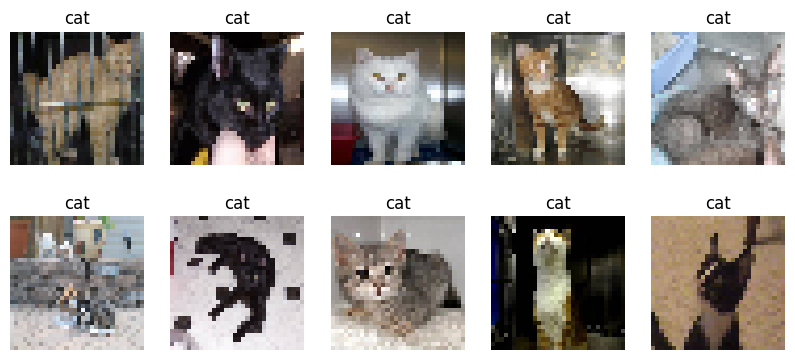

In [14]:
indexes = np.random.randint(100, 300, 10)
show_images_batch(X_train[indexes], 
                  names=y_train[indexes])

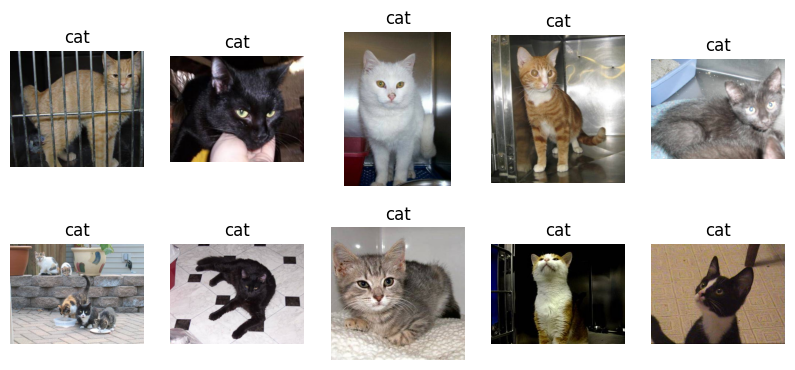

In [15]:
show_images_files([train_map[i] for i in indexes], 
                  names=y_train[indexes])

We only get cats because they are sorted, let's take a look at some cute puppies.

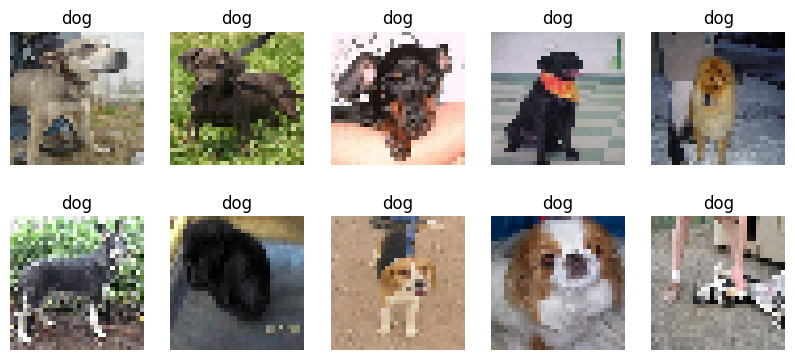

In [16]:
indexes = np.random.randint(2000, 2300, 10)
show_images_batch(X_train[indexes], 
                  names=y_train[indexes])

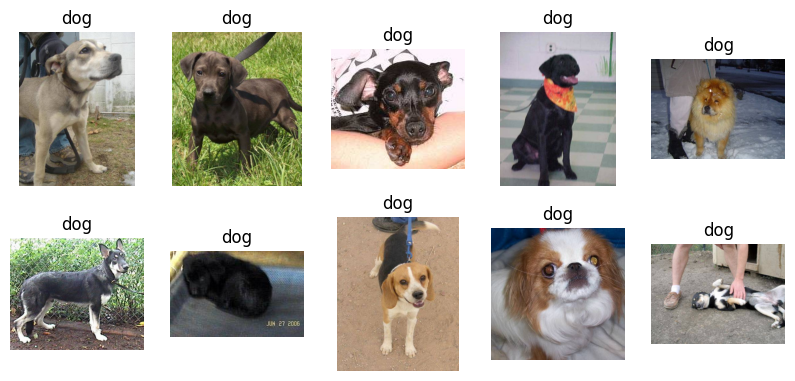

In [17]:
show_images_files([train_map[i] for i in indexes], 
                  names=y_train[indexes], 
                  train=2, 
                  train_index=2)

As in any ML or DL model, we are going to analyze the target of the subset.

In [19]:
pd.Series(y_train).value_counts(normalize=True)

cat    0.5
dog    0.5
Name: proportion, dtype: float64

We have a completely balanced dataset for a binary classification problem.


In [20]:
X_train.shape

(4000, 32, 32, 3)

### Scaling

It is always interesting to apply scaling, even in the case of images where the channels are already "scaled" between 0 and 255. Reducing the range from 0/255 to -1/1 or 0/1 takes better advantage of activation functions and avoids saturation issues.


In [21]:
# Scaling
X_train = X_train / 255
X_test = X_test / 255

## Shuffle (Optional)

Since the data is ordered, it is necessary to introduce some randomness, even though the data will be processed randomly when building the batches internally.

EXTRA: We build a random forest as a baseline.


In [23]:
def flatten_grayscale(array_in, grayscale=True):
    """
    Flattens the input array and optionally converts it to grayscale.
    """
    def convert_to_grayscale(color_image):
        # Coefficients for RGB to grayscale conversion. Note 2 different colors could be the same grayscale
        coefficients = np.array([0.2989, 0.5870, 0.1140])
        grayscale_image = np.dot(color_image[..., :3], coefficients)  # Linear combination for grayscale
        return grayscale_image

    # Convert to grayscale if the input is RGB and grayscale is True
    if array_in.shape[-1] == 3 and grayscale:
        array_in = np.array([convert_to_grayscale(image) for image in array_in])

    # Flatten the array
    return array_in.reshape(array_in.shape[0], -1)

In [24]:
# Prepare train set
X_train_rf = flatten_grayscale(X_train)
len(X_train_rf[0]) # 32 x 32 flattened pixels


1024

In [25]:
# Shuffle
X_train_rf_shuffled, y_train_shuffled = shuffle(X_train_rf, y_train, random_state=42)

In [26]:
y_train[0:10]

array(['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
       'cat'], dtype='<U3')

In [27]:
y_train_shuffled[0:10]

array(['cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat',
       'cat'], dtype='<U3')

In [28]:
# Baseline model
rf_clf = RandomForestClassifier()
np.mean(cross_val_score(rf_clf, X_train_rf_shuffled, y_train_shuffled, cv=5, scoring="accuracy"))

np.float64(0.6045)

An accuracy of 60.5 % is quite low, but it is the minimum we should expect.

### Extra-Tool: Save data

We can save the NumPy arrays into a .npz file, so that it can be imported more quickly later.


In [29]:
np.savez(PATH_DATA + "data.npz", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

And load the data.


In [30]:
data = np.load(PATH_DATA + "data.npz")

X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]

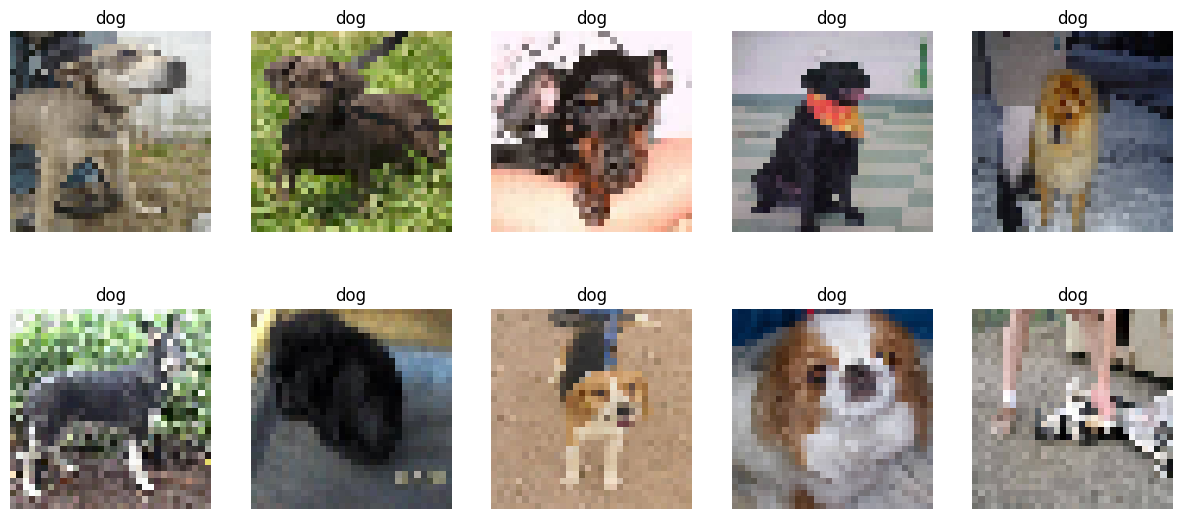

In [31]:
show_images_batch(X_train[indexes], y_train[indexes], size_scale=3)

## 2. Model Development

When creating a DL model, remember that we need to set a series of initial hyperparameters. It's not like when we instantiate models in Sklearn, which come "preconfigured." The typical order in this case is:

1. Topology (I): Layers, connections between layers. We will perform feature expansion-reduction, reduction-expansion, prisms, flattening, dropout, etc.

2. Topology (II): Hyperparameters per layer: units for dense layers, kernel, strides, filters, padding for convolutional and pooling layers, dropout rate for dropout, etc.

3. Other Hyperparameters: Type of optimizer (and its hyperparameters; in general, we will use the defaults, except occasionally for the learning rate), batch size (though it will usually be 32 and depend on the size of the training dataset), training epochs, validation set percentage.

4. Metric and Loss Function

5. Use of Callbacks (in Keras): Generally, we will use EarlyStopping and/or ModelCheckpoint, but [here](https://keras.io/api/callbacks/) you can find several more standard Keras callbacks.




### Topology I-II

Let's create a topology similar to the one in the figure.

![CNN](../img/cnn.png)

- Convolutional Layer: Extracts different features from the images.
- Pooling Layer: Reduces the dimensions of the images after a convolutional layer.
- Fully Connected Layer: After the convolutional layers, the extracted features are flattened and fed into a standard neural network.
- Output Layer: The network's predictions.

With the following hyperparameters:

**First Conv-Pooling Block:**

- Convolutional Layer: Kernel size = 3x3, stride = (1,1), padding = "same", activation = "ReLU", number of filters = 64.
- Pooling Layer: Max pooling, kernel size = 2x2, stride = (2,2) → Reduces the feature map by a factor of 4 (2x2).
- Output Features: 16 × 16 × 64 = 16,384.
- Dropout Layer: Dropout rate = 0.25.

**Second Conv-Pooling Block:** (Expansion phase, increasing the number of filters to extract higher-level features.)

- Convolutional Layer: Kernel size = 3x3, stride = (1,1), padding = "same", activation = "ReLU", number of filters = 128.
- Pooling Layer: Max pooling, kernel size = 2x2, stride = (2,2) → Reduces the feature map by a factor of 4 (2x2).
- Output Features: 8 × 8 × 128 = 8,192.
- Dropout Layer: Dropout rate = 0.25.

**Flatten Layer:**

- Flatten() → Converts each instance into a vector of 8,192 features.

**Classification Head:**

- A fully connected layer followed by the output layer. We start by reducing the feature space from 8,192 to 512 (a reduction factor of 16). Alternatively, we could have used 1,024 features (32 × 32), which would be a typical choice in traditional models.

**Hidden Dense Layer:**

- 128 units, activation = "ReLU".

**Output Dense Layer:**

- 1 unit (binary classification), activation = "Softmax".

In [32]:
# Define the model architecture
layers = [
    keras.layers.Input(shape=(32, 32, 3)),

    # First Convolutional Block
    # Padding options: "valid" (no padding), "same" (keeps dimensions), integer (custom padding).
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),  
    # The output consists of 64 transformed feature maps, each of size 32x32.
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
    # Reduces spatial dimensions by half: 32x32 -> 16x16.
    keras.layers.Dropout(rate=0.25),

    # Second Convolutional Block
    # Generates 128 feature maps per input
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),  
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
    # Further reduces dimensions: 16x16 -> 8x8.
    keras.layers.Dropout(rate=0.25),

    # Flattening Layer
    # Computes: 1 * 32 * 32 * 64 * 0.5 * 0.5 * 128 * 0.5 * 0.5 = 524,288 new features per original 32x32 image (across all 3 color channels).
    keras.layers.Flatten(),  

    # Fully Connected Layers
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(rate=0.5),

    # Output Layer
    # keras.layers.Dense(2, activation="softmax")  
    # Use loss="sparse_categorical_crossentropy" (for categorical_crossentropy, y_train should be one-hot encoded, e.g., [0,1] or [0,0,1,0,0]).
    keras.layers.Dense(1, activation="sigmoid")  
    # Use loss="binary_crossentropy" for binary classification.
]

# Initialize the model
model = keras.Sequential(layers)


### Other hyperparameters

Let's check the input data size:

In [44]:
X_train.shape

(4000, 32, 32, 3)

In [45]:
X_train.size

12288000

Adam optimizer should work well, but we could also try SGD.

In [46]:
optimizer = keras.optimizers.Adam()

In [47]:
metrics = ["accuracy"] # balanced dataset
loss = "binary_crossentropy" # binary classificator

We have 4,000 instances, which is not a large dataset, so we will use a batch size of 32.


In [48]:
batch_size = 32
print(len(X_train) / batch_size)

125.0


Each epoch will consist of 125 training steps, also known as iterations. We could even increase the batch size to 48 or 64.

We choose a high number of epochs and use EarlyStopping with a patience of 10 to avoid relying solely on the predefined number of epochs.

In [49]:
num_epochs = 100

In [50]:
earlyS = keras.callbacks.EarlyStopping(patience=10)

We compile the model and display a summary of its architecture.

In [51]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,270,977 (16.29 MB)

 Trainable params: 4,270,977 (16.29 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Model Training

It's time to train the model and display the training progress. However, first, let's run a single epoch to check the timing, and before that, we need to convert the target variable to numeric.

In [53]:
# Labels are strings
y_train[np.array([1,2,3560])]

array(['cat', 'cat', 'dog'], dtype='<U3')

In [54]:
# Labels must be a NumPy array, otherwise fit will not accept it if we want to use a validation set
y_train_num = np.array([0 if y == "cat" else 1 for y in y_train]) 

Since we will need to run multiple training sessions to simulate weight resets, we create a function that handles this for us. It returns the model, ready for a new fit.


In [55]:
def prepare_model(resolution=(32, 32)):
    """
    Creates and compiles a CNN model for binary classification.
    """
    layers = [
        keras.layers.Input((32, 32, 3)),
        keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        keras.layers.Dropout(rate=0.25),

        keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same"),
        keras.layers.Dropout(rate=0.25),

        keras.layers.Flatten(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(1, activation="sigmoid")
    ]
    
    model = keras.Sequential(layers)
    optimizer = keras.optimizers.Adam()
    metrics = ["accuracy"]  # Balanced dataset
    loss = "binary_crossentropy"  # Binary classifier
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model


In [56]:
model = prepare_model()
t_zero = time()
history = model.fit(X_train,
                    y_train_num,
                    epochs=1,   # Just 1 epoch
                    batch_size=batch_size,
                    callbacks=[earlyS],
                    validation_split=0.2)
dur_epoch = time() - t_zero   # Duration of the epoch

100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6243 - loss: 0.7108 - val_accuracy: 0.0000e+00 - val_loss: 0.9230


In [57]:
print(dur_epoch)

4.299394607543945


Each epoch lasts about 5 seconds, so we can use a high number of epochs. However, we should be cautious if the results are excessively positive, as we might need to investigate further.


In [58]:
model = prepare_model()
t_zero = time()
history = model.fit(X_train,
            y_train_num,
            epochs=num_epochs,
            batch_size=batch_size,
            callbacks=[earlyS],     # early stop of 10 epochs
            validation_split=0.2)
dur_epoch = time() - t_zero

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5764 - loss: 0.8298 - val_accuracy: 0.0000e+00 - val_loss: 0.7375
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6182 - loss: 0.6615 - val_accuracy: 0.0000e+00 - val_loss: 0.8178
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6216 - loss: 0.6445 - val_accuracy: 0.8012 - val_loss: 0.5696
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6669 - loss: 0.6135 - val_accuracy: 0.7663 - val_loss: 0.6249
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6881 - loss: 0.5890 - val_accuracy: 0.3325 - val_loss: 0.8867
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7101 - loss: 0.5666 - val_accuracy: 0.6562 - val_loss: 0.6499
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7180 - loss: 0.5533 - val_accuracy: 0.7462 - val_loss: 0.5258
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7319 - loss: 0

In [45]:
# By default, EarlyStopping does not retain the previous best model before stopping.
y_test_num = np.array([0 if y == "cat" else 1 for y in y_test])
model.evaluate(X_test,y_test_num)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7587 - loss: 0.5747


[0.5727477073669434, 0.7590000033378601]

In [59]:
# The default batch_size for evaluate is 32.
model.metrics_names

['loss', 'compile_metrics']

In [60]:
X_test.shape

(1000, 32, 32, 3)

In [61]:
# so there are 32 steps per epoch (rounded to the nearest integer)
1000/32 

31.25

These results might be affected by the order of the input data, as it was initially sorted (first cats, then dogs). Let's shuffle the data.


In [62]:
# Shuffle
X_s, y_s = shuffle(X_train, y_train_num)

In [63]:
# Fit with shuffled data
model = prepare_model()
t_zero = time()
history_shuffle = model.fit(X_s,
                            y_s,
                            epochs=num_epochs,
                            batch_size=batch_size,
                            callbacks=[earlyS],
                            validation_split=0.2)
dur_epoch = time() - t_zero

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.5008 - loss: 0.7458 - val_accuracy: 0.5213 - val_loss: 0.6849
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5775 - loss: 0.6669 - val_accuracy: 0.6575 - val_loss: 0.6208
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6836 - loss: 0.6007 - val_accuracy: 0.5938 - val_loss: 0.6665
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7020 - loss: 0.5655 - val_accuracy: 0.7150 - val_loss: 0.5696
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7192 - loss: 0.5435 - val_accuracy: 0.7237 - val_loss: 0.5925
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7376 - loss: 0.5266 - val_accuracy: 0.7175 - val_loss: 0.5691
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7751 - loss: 0.4843 - val_accuracy: 0.7000 - val_loss: 0.5632
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7816 - loss: 0.4591 - 

In [64]:
y_test_num = np.array([0 if y == "cat" else 1 for y in y_test])
model.evaluate(X_test, y_test_num)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7251 - loss: 0.7637


[0.7049298286437988, 0.7379999756813049]

Let's plot the evolution of both trainings.


In [65]:
df_evol = pd.DataFrame(history.history)
df_evol_shuffle = pd.DataFrame(history_shuffle.history)

<Axes: >

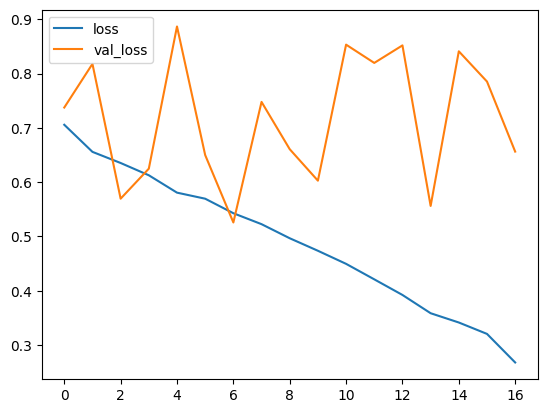

In [66]:
df_evol[["loss", "val_loss"]].plot()

<Axes: >

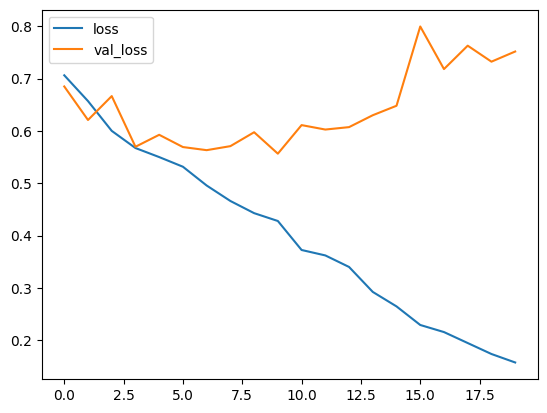

In [67]:
df_evol_shuffle[["loss","val_loss"]].plot()

We don't always need to stop as soon as the validation and training curves diverge, but we also shouldn't wait too long. Not shuffling initially causes more oscillation in the training without shuffling, but in this case, the impact has been minimal (since shuffling is enabled by default in the Keras fit function).


## 4. Model Evaluation

In [68]:
predictions = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [69]:
y_pred = ["dog" if prediction[0] > 0.5 else "cat" for prediction in model.predict(X_test)]
print(classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

         cat       0.75      0.71      0.73       500
         dog       0.73      0.76      0.74       500

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



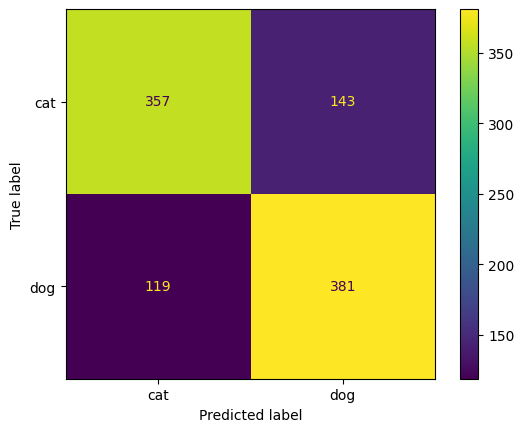

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## 5. Selecting the Most Challenging Images

Let's take advantage of the fact that the test data is also ordered:

If the probability is less than 0.5:
I will consider it is a cat, and I will be more confident in this prediction the lower the probability is (i.e., 1 - probability).

If the probability is greater than 0.5:
I will consider it is a dog, and I will be more confident in this prediction the higher the probability is (i.e., probability).

In [71]:
confidence = [ (1-prediction[0]) if prediction[0] <= 0.5 else prediction[0] for prediction in model.predict(X_test)]
df_pred = pd.DataFrame({"File": test_map,"True": [file.split(".")[0] for file in test_map],"Prediction": y_pred, "Confidence": confidence})
df_pred

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,File,True,Prediction,Confidence
0,cat.10705.jpg,cat,dog,0.514820
1,cat.10711.jpg,cat,cat,0.738901
2,cat.10714.jpg,cat,cat,0.882145
3,cat.10715.jpg,cat,cat,0.533014
4,cat.10716.jpg,cat,dog,0.938102
...,...,...,...,...
995,dog.9883.jpg,dog,dog,0.898991
996,dog.9884.jpg,dog,dog,0.990216
997,dog.9885.jpg,dog,dog,0.882919
998,dog.9889.jpg,dog,dog,0.800598


In [72]:
errors = df_pred["True"] != df_pred["Prediction"]
is_cat = df_pred["True"] == "cat"
is_dog = df_pred["True"] == "dog"
difficult_cats  = df_pred[is_cat & errors]["Confidence"].nlargest(int(len(df_pred[is_cat & errors])*0.1)).index.to_list()
difficult_dogs  = df_pred[is_dog & errors]["Confidence"].nlargest(int(len(df_pred[is_dog & errors])*0.1)).index.to_list()


In [73]:
df_pred.loc[difficult_cats ]

,File,True,Prediction,Confidence
337,cat.11793.jpg,cat,dog,1.000000
13,cat.10740.jpg,cat,dog,0.999762
368,cat.11899.jpg,cat,dog,0.999762
153,cat.11168.jpg,cat,dog,0.999662
455,cat.12184.jpg,cat,dog,0.999099
229,cat.11462.jpg,cat,dog,0.997730
175,cat.11240.jpg,cat,dog,0.996981
359,cat.11867.jpg,cat,dog,0.995837
7,cat.10726.jpg,cat,dog,0.994891
154,cat.11169.jpg,cat,dog,0.993963


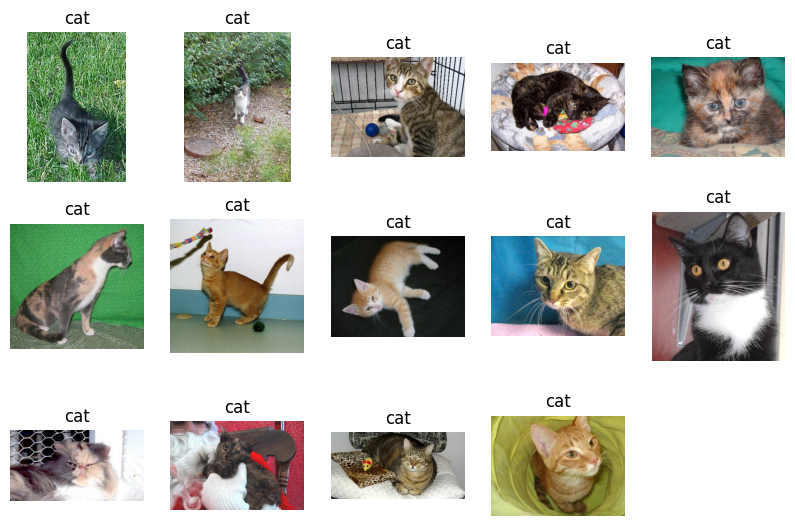

In [74]:
show_images_files(df_pred.loc[difficult_cats ]["File"], df_pred.loc[difficult_cats ]["True"].values, train=False)

In [75]:
df_pred.loc[difficult_dogs ]

,File,True,Prediction,Confidence
871,dog.9449.jpg,dog,cat,0.999929
643,dog.8624.jpg,dog,cat,0.999865
662,dog.8696.jpg,dog,cat,0.999562
851,dog.9346.jpg,dog,cat,0.999454
923,dog.9625.jpg,dog,cat,0.999209
893,dog.9530.jpg,dog,cat,0.999111
509,dog.8117.jpg,dog,cat,0.998519
598,dog.8451.jpg,dog,cat,0.997511
833,dog.9270.jpg,dog,cat,0.997336
680,dog.8764.jpg,dog,cat,0.996254


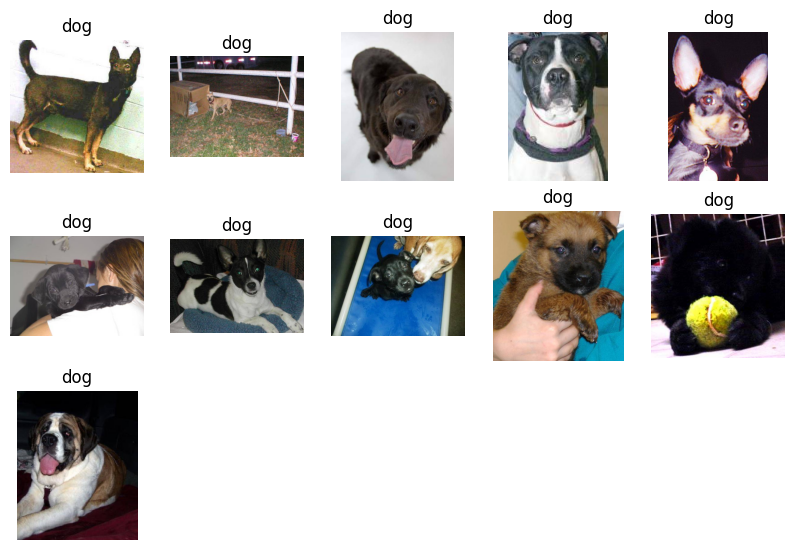

In [77]:
show_images_files(df_pred.loc[difficult_dogs ]["File"], df_pred.loc[difficult_dogs ]["True"].values, train=False)

The discussion is whether the resolution affects the model's performance. It does, and we should consider that resolution when making assumptions. On the other hand, the fact that these are images that would not be challenging for a human but are difficult for a model makes them more suitable for the task, as failing to classify them correctly is a clear sign that it's a model.


## Bonus Track

To conclude, let's explore one of the techniques that can be used to provide more information to an image classifier (which could also serve, to some extent, as a synthetic generation or oversampling technique to balance datasets).

Let's see how to use Keras dataset augmenters for images.


### Image data generator

First, let's take the training data and build a dataset with the structure filename-category, which will be useful later to explore another capability of Keras.


In [84]:
paths  = [f"{PATH_DATA}github_train_{i}" for i in range(0,4)]
files = []
classes = []
for path in paths:
    files += [path + "/" + file for file in os.listdir(path)]
    classes += [file.split(".")[0] for file in os.listdir(path)]
    
train_augmented = pd.DataFrame({"filename": files, "category": classes})
train_augmented.head(10)


,filename,category
0,../data/pets/github_train_0/cat.1000.jpg,cat
1,../data/pets/github_train_0/cat.10010.jpg,cat
2,../data/pets/github_train_0/cat.10012.jpg,cat
3,../data/pets/github_train_0/cat.10013.jpg,cat
4,../data/pets/github_train_0/cat.10017.jpg,cat
5,../data/pets/github_train_0/cat.1002.jpg,cat
6,../data/pets/github_train_0/cat.10023.jpg,cat
7,../data/pets/github_train_0/cat.10024.jpg,cat
8,../data/pets/github_train_0/cat.10027.jpg,cat
9,../data/pets/github_train_0/cat.10030.jpg,cat


The ImageDataGenerator object will help us generate a modified version of an original image through rotations, rescaling, translations, zooms, flips, and other augmentations.


In [85]:
# It does not generate X synthetic images. Instead, during each epoch, instead of using 
# the dataset as is, it uses one of these synthetic images, which are slightly different. 
# This way, it increases the perspective of the images. 
# The images are generated while training.

example_df = train_augmented.sample(n=1).reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15,       # Rotation angle
    rescale=1./255,          # Rescaling, scales the images
    shear_range=0.1,         # Shear transformations, not a rotation but an inclination (like italicizing)
    zoom_range=0.2,          # Zoom
    horizontal_flip=True,    # Horizontal flip or mirror
    width_shift_range=0.1,   # Horizontal pixel shift
    height_shift_range=0.1   # Vertical pixel shift
)


Two ways to use it: 
- From file reading 
- From data

In [86]:
example_df

,filename,category
0,../data/pets/github_train_3/dog.11959.jpg,dog


In [87]:
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    x_col="filename",
    y_col="category",
    target_size=(32, 32)
    )


Found 1 validated image filenames belonging to 1 classes.


Now we generate 15 synthetic images, applying the transformations randomly.


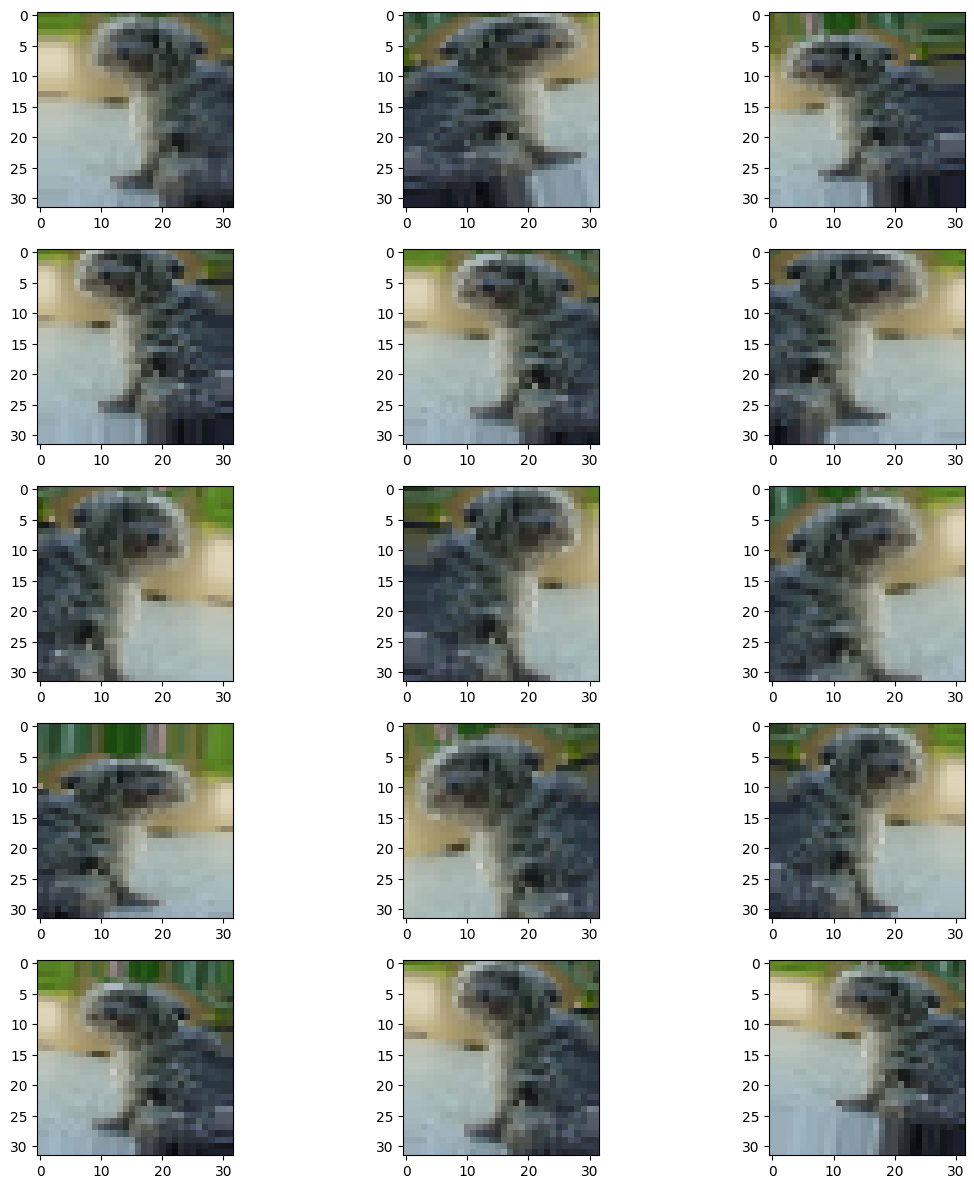

In [88]:
plt.figure(figsize=(12, 12))

# Generate augmented images from one in this case
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
    
plt.tight_layout()
plt.show() 

In [89]:
example_generator = train_datagen.flow(
    X_train[0:3]*255,
    y_train[0:3]
    )


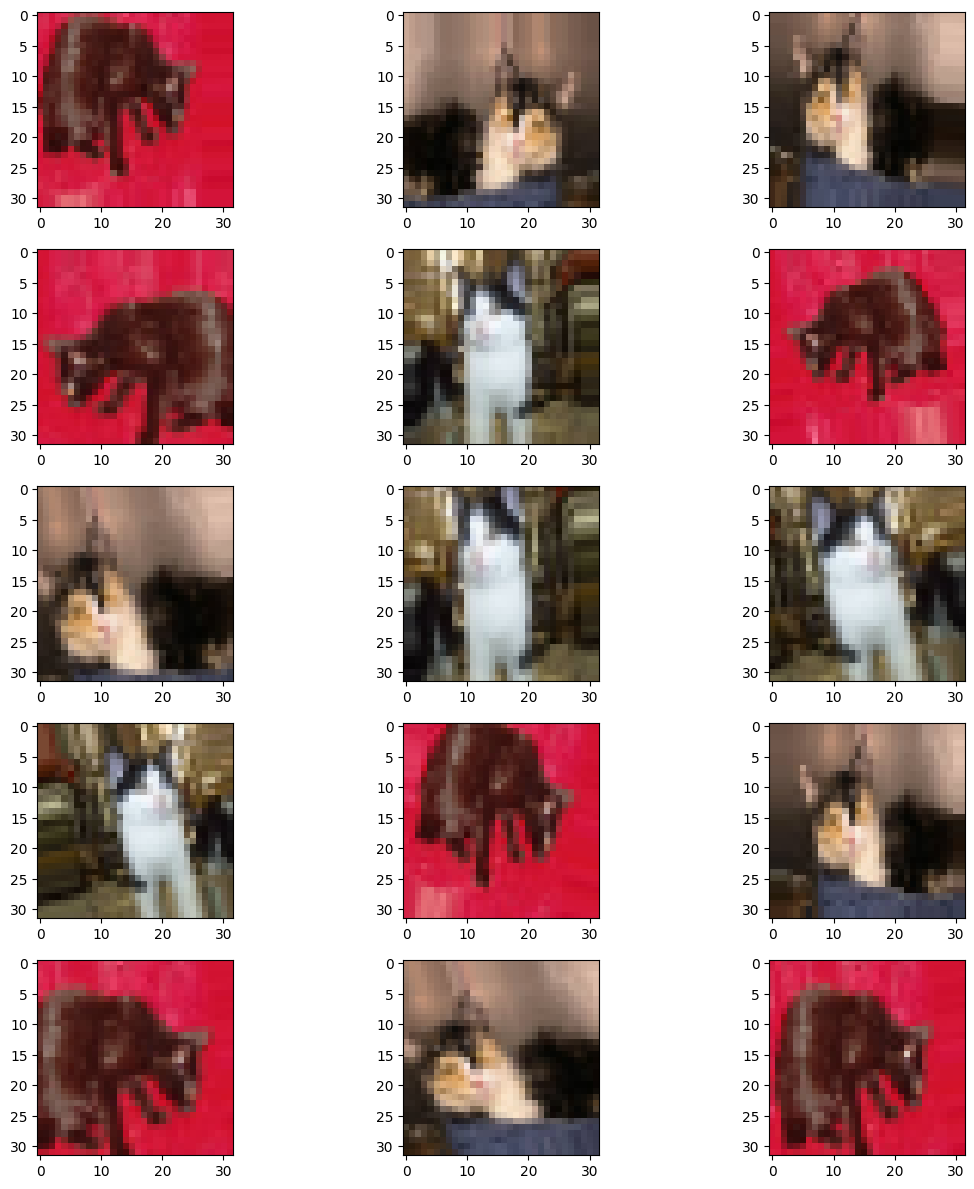

In [90]:
plt.figure(figsize=(12, 12))

# Generate augmented images from three in this case
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show() 

### Applied to a model and training

We need to generate the validation dataset separately, as it will not have augmentation.


In [91]:
# train_augmented is a DataFrame where each row corresponds to a different augmented version of an image
train_df, validate_df = train_test_split(train_augmented,
                                         test_size=0.20,
                                         random_state=42)

In [92]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [93]:
train_df

,filename,category
0,../data/pets/github_train_3/dog.9982.jpg,dog
1,../data/pets/github_train_0/cat.2440.jpg,cat
2,../data/pets/github_train_2/dog.9981.jpg,dog
3,../data/pets/github_train_1/cat.1657.jpg,cat
4,../data/pets/github_train_0/cat.2753.jpg,cat
...,...,...
3195,../data/pets/github_train_1/cat.1303.jpg,cat
3196,../data/pets/github_train_1/cat.1882.jpg,cat
3197,../data/pets/github_train_0/cat.487.jpg,cat
3198,../data/pets/github_train_3/dog.11270.jpg,dog


In [94]:
total_train = train_df.shape[0]
total_val = validate_df.shape[0] # no cross-validation

print("Shape train", total_train)
print("Shape validation", total_val)
validate_df.head()

Shape train 3200
Shape validation 800


,filename,category
0,../data/pets/github_train_0/cat.2936.jpg,cat
1,../data/pets/github_train_3/dog.11231.jpg,dog
2,../data/pets/github_train_0/cat.2820.jpg,cat
3,../data/pets/github_train_3/dog.12368.jpg,dog
4,../data/pets/github_train_2/dog.9978.jpg,dog


### Training Generator

In [95]:
# 'class_mode' is set to 'binary' because it's a binary classification problem.
# If it were a multi-class problem, you would use 'sparse' or 'categorical' (depending on the encoding of labels).
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="category",
    target_size=(32, 32),
    class_mode="binary",  # Use "sparse" for multi-class classification with integer labels
    batch_size=batch_size
)


Found 3200 validated image filenames belonging to 2 classes.


### Validation Generator

In [96]:
# Only rescaling is applied here
validation_datagen = ImageDataGenerator(rescale=1./255) 
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    x_col="filename",
    y_col="category",
    target_size=(32, 32),
    class_mode="binary",
    batch_size= batch_size
)

Found 800 validated image filenames belonging to 2 classes.


### Fit Model

In [97]:
model = keras.Sequential(layers)

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [98]:
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=earlyS
    )

Epoch 1/100


c:\Users\Lander\Documents\GitHub\deep_learning_images\.venv_images\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.5143 - loss: 0.7458 - val_accuracy: 0.4725 - val_loss: 0.6959
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.5578 - loss: 0.6827 - val_accuracy: 0.6125 - val_loss: 0.6451
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6090 - loss: 0.6613 - val_accuracy: 0.6875 - val_loss: 0.6100
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6146 - loss: 0.6555 - val_accuracy: 0.6425 - val_loss: 0.6231
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6443 - loss: 0.6305 - val_accuracy: 0.6862 - val_loss: 0.6056
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.6562 - loss: 0.6166 - val_accuracy: 0.6500 - val_loss: 0.6113
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6793 - loss: 0.6074 - val_accuracy: 0.7063 - val_loss: 0.5823
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6649 - loss: 0.6078 - val_accuracy

In [99]:
results = model.evaluate(X_test, y_test_num)
print("test loss, test acc:", results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6258 - loss: 0.6615
test loss, test acc: [0.5279046893119812, 0.7319999933242798]


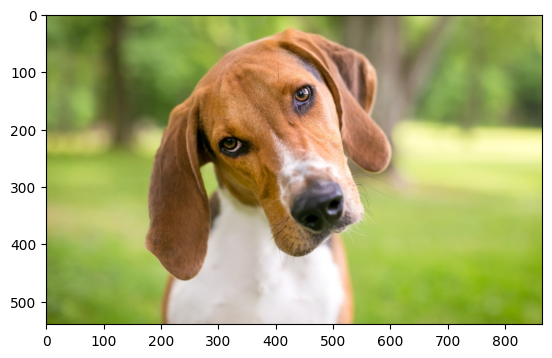

In [100]:
image = imread("../img/dog_test.jpg")
plt.imshow(image);

In [101]:
image = np.array([cv2.resize(image, (32, 32))/255])
image.shape

(1, 32, 32, 3)

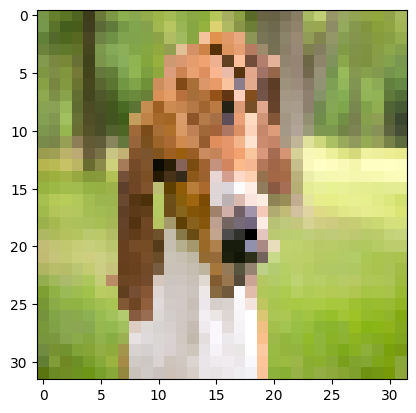

In [102]:
plt.imshow(image[0])

In [103]:
image.shape

(1, 32, 32, 3)

In [104]:
predictions = model.predict(image).round(3)
print("predictions shape:", predictions.shape)
predictions     # dog!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
predictions shape: (1, 1)


array([[0.978]], dtype=float32)